# Прогнозирование стоимости автомобиля по характеристикам
Цель:  
Разработать Multi-input модель для предсказания стоимости автомобиля по различным данным - табличным, текстовым и графическим.

Задачи:  


## Этапы проекта:
* Построение "наивной"/baseline модели, предсказывающей цену по модели и году выпуска (с ней будем сравнивать другие модели)
* EDA и Feature-Engeneering
* В рамках исследования будет создана модель на основе градиентного бустинга с использованием CatBoost
* Исследование табличной нейронной сети
* Комбинирование табличной нейронной сети и NLP в одну multi-input сеть с дальнейшей проверкой метрики
* Исследование нейронной сети для обработки изображений и добавление ее в multi-input сеть
* Ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

# 0. Установка и загрузка библиотек

In [168]:
!pip install --upgrade pip

In [169]:
!pip install -q tensorflow==2.3

In [170]:
# аугментации изображений
!pip install albumentations -q

In [171]:
!pip install pymorphy2
!pip install pymorphy2-dicts

In [172]:
!pip install catboost

In [173]:
!pip install category_encoders


In [174]:
import os
import re
import cv2 
import sys
import csv
import PIL
import random
import pickle
import zipfile
import pymorphy2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from nltk.corpus import stopwords
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

from category_encoders.binary import BinaryEncoder

# keras
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.callbacks import (
    Callback, 
    ModelCheckpoint, 
    EarlyStopping,
    ReduceLROnPlateau,
    LearningRateScheduler, 
)
from tensorflow.keras.optimizers.schedules import *
import albumentations as a

import PIL
from PIL import ImageOps, ImageFilter

# plt
import matplotlib.pyplot as plt
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

#pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

Посмотрим версии используемых библиотек

In [175]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.13 (default, Apr 24 2022, 01:04:09) 
Numpy        : 1.21.6
Tensorflow   : 2.3.0


Зафиксируем версию пакетов:

In [176]:
!pip freeze > requirements.txt

Теперь установим random seed:

In [177]:
RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)

Вспомогательный флаг для удобства использования на раных платформах

In [178]:
# True - для Google Colab
# False - для Kaggle
is_colab = True

Пропишем функцию для вычисления метрики MAPE

In [179]:
def mape(y_test, y_pred):
    return np.mean(np.abs((y_pred-y_test)/y_test))

# 1. DATA

Пути к данным и рабочим папкам

In [180]:
if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

if is_colab:
    # Colab
    DATA_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks'
                                '/project_8/input'
                                '/sf-dst-car-price-prediction-part2/')
    SAVE_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks'
                                '/project_8/saves_models')
    WORK_PATH = os.path.join(os.getcwd(), 'working')
else:
    # Kaggle
    DATA_PATH = os.path.abspath('../input/sf-dst-car-price-prediction-part2/')
    SAVE_PATH = os.path.abspath('../input/saves-models')
    WORK_PATH = os.path.abspath('./')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузим наш обучающий и тестовый фреймы:

In [181]:
train = pd.read_csv(os.path.join(DATA_PATH,'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH,'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH,'sample_submission.csv'))

Проверим, что у нас находится в обучающем и тестовом фреймах

In [182]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [183]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [184]:
train.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

Мы видим, что присутствуют пропуски, которые в дальнейшем придется обработать каким-либо способом.  

Проверим что находится в тестовом фрейме:

In [185]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

In [186]:
test.nunique()

bodyType                  14
brand                      3
color                     15
description             1540
engineDisplacement        43
enginePower              120
fuelType                   4
mileage                  935
modelDate                 37
model_info               101
name                     536
numberOfDoors              4
productionDate            35
sell_id                 1671
vehicleConfiguration     205
vehicleTransmission        4
Владельцы                  3
Владение                 131
ПТС                        2
Привод                     3
Руль                       1
dtype: int64

In [187]:
test.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  0
Владение                1092
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

Здесь пропуски имеются только в столбце "владение". В дальнейшем нужно будет обработать.

In [188]:
train.sample(7)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
2221,седан,AUDI,белый,Дилерская \nЯ второй хозяин\n2 комплекта колес...,1.8 LTR,190 N12,бензин,125000,2014,A6,1.8 AMT (190 л.с.),4,1350000.0,2016,1099322762,SEDAN ROBOT 1.8,роботизированная,2 владельца,NaN,Оригинал,передний,Левый
488,седан,MERCEDES,чёрный,БЕЗ ТОРГА! Собственник. Дилерский автомобиль.\...,5.5 LTR,388 N12,бензин,162000,2005,S_KLASSE,500 5.5 AT (388 л.с.) 4WD,4,799000.0,2008,1098188416,SEDAN AUTOMATIC 5.5,автоматическая,3 или более,8 месяцев,Оригинал,полный,Левый
6122,внедорожник 5 дв.,BMW,чёрный,Автомобиль из собственного парка компании АВТО...,3.0 LTR,249 N12,дизель,270,2017,X3,30d xDrive 3.0d AT (249 л.с.) 4WD,5,4379999.0,2020,1099786652,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый
5866,внедорожник 5 дв.,MERCEDES,чёрный,Итак Доброго времени суток!) \nПро авто: наход...,3.0 LTR,249 N12,дизель,166500,2011,M_KLASSE,350 CDI 3.0d AT (249 л.с.) 4WD,5,1650000.0,2013,1097810350,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
2596,внедорожник 5 дв.,BMW,коричневый,BMW X6 M Competition M Special\n\nБензин\nМощн...,4.4 LTR,625 N12,бензин,20,2019,X6_M,Competition 4.4 AT (625 л.с.) 4WD,5,12900000.0,2020,1100209540,ALLROAD_5_DOORS AUTOMATIC 4.4,автоматическая,1 владелец,NaN,Оригинал,полный,Левый
6150,седан,BMW,серый,"Sportline, куплена в кредит. При вас выкупим и...",2.0 LTR,190 N12,дизель,14500,2016,5ER,520d 2.0d AT (190 л.с.),4,2950000.0,2019,1099668716,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,9 месяцев,Оригинал,задний,Левый
5336,внедорожник 5 дв.,MERCEDES,серебристый,Продаю свой автомобиль \nАвтомобиль в 2009 при...,5.0 LTR,306 N12,бензин,211000,2005,M_KLASSE,500 5.0 AT (306 л.с.) 4WD,5,520000.0,2005,1097050114,ALLROAD_5_DOORS AUTOMATIC 5.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый


In [189]:
test.sample(7)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
951,внедорожник 5 дв.,BMW,чёрный,"В продаже автомобиль от компании АО ABTODOM, о...",2.0 LTR,192 N12,бензин,59515,2015,X1,20i xDrive 2.0 AT (192 л.с.) 4WD,5,2016,1099787962,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый
1418,внедорожник 5 дв.,MERCEDES,белый,Один владелец. Автомобиль в хорошем состоянии....,2.1 LTR,170 N12,дизель,117000,2008,GLK_KLASSE,220 CDI 2.1d AT (170 л.с.) 4WD,5,2011,1080178040,ALLROAD_5_DOORS AUTOMATIC 2.1,автоматическая,1 владелец,8 лет и 11 месяцев,Оригинал,полный,Левый
1197,внедорожник 5 дв.,BMW,белый,Автомобиль в хорошем состоянии. Несмотря на см...,2.0 LTR,184 N12,бензин,243000,2010,X3,20i xDrive 2.0 AT (184 л.с.) 4WD,5,2012,1100130288,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1626,хэтчбек 5 дв.,MERCEDES,белый,Внимание! Только для клиентов AVILON Автомобил...,1.7 LTR,116 N12,бензин,108298,2008,A_KLASSE,180 1.7 CVT (116 л.с.),5,2011,1100155258,HATCHBACK_5_DOORS VARIATOR 1.7,вариатор,3 или более,NaN,Оригинал,передний,Левый
319,седан,AUDI,белый,"Автоцентр ОВОД, Официальный дилер Nissan, 22 г...",2.0 LTR,211 N12,бензин,192000,2007,A4,2.0 AMT (211 л.с.) 4WD,4,2011,1099523410,SEDAN ROBOT 2.0,роботизированная,3 или более,NaN,Оригинал,полный,Левый
1430,седан,MERCEDES,серебристый,БОЛЕЕ 350 А/М В НАЛИЧИИ\nКЛЮЧАВТО — это официа...,3.2 LTR,218 N12,бензин,237500,2000,C_KLASSE,320 3.2 AT (218 л.с.) 4WD,4,2004,1100255524,SEDAN AUTOMATIC 3.2,автоматическая,3 или более,NaN,Оригинал,полный,Левый
138,седан,MERCEDES,коричневый,"[Smart]\nОригинал ПТС, По факту один владелец,...",1.6 LTR,150 N12,бензин,49484,2013,CLA_KLASSE,200 1.6 AMT (150 л.с.),4,2016,1100140994,SEDAN ROBOT 1.6,роботизированная,1 владелец,NaN,Оригинал,передний,Левый


В обоих датафреймах столбцы совпадают.

Определим типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - содержит информацию, содержащуюся в других признаках
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

Теперь попробуем создать наивную модель и посмотреть результат нашей метрики

# 2. Model 0: "Наивная" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



Первым делом проведем разделенение на обучающую и валидационную выборки:

In [190]:
data_train, data_test = train_test_split(
    train, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

Создадим наивную модель и проведем оценку отчности:

In [191]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 
                                          'productionDate']]).iterrows():
    predicts.append(data_train.loc[(data_train['model_info'] == row[0]) & 
                                   (data_train['productionDate'] == row[1])]
                    ['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000
# print(data_test['price'].values)
# print(predicts.values[:, 0])

# оцениваем точность
print(f"Ошибка по метрике MAPE: "
      f"{(mape(data_test['price'].values, predicts.values[:, 0]))*100:0.2f}%")


Ошибка по метрике MAPE: 20.26%


Мы получили достаточно плохой результат, но теперь появилось понимание - откуда отталкиваться. 

Первым делом проведем EDA и попробуем использовать CatBoost.

# 3. EDA и Feature-Engeneering

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм. По большей части EDA и Feature-Engeneering был произведен в одном из предыдущих проектов CarPricePrediction, поэтому многие вещи будут заимствованы оттуда.

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

## Предобработка табличных данных

Объединим тестовый и обучающий фреймы в один:

In [192]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1  # трейн
test['sample'] = 0  # тест
test['price'] = 0  # в тесте нет значения price,  заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True)  # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


Теперь приступим к предобработке



## Сначала поработаем с числовыми признаками. 

### engineDisplacement

Этот признак описывает объем двигателя авто. Посмотрим количество уникальных значений :

In [193]:
data.engineDisplacement.unique()

array(['3.0 LTR', '2.5 LTR', '2.0 LTR', '3.5 LTR', '1.8 LTR', '2.2 LTR',
       '5.5 LTR', '4.8 LTR', '1.6 LTR', '4.7 LTR', '4.0 LTR', '1.5 LTR',
       '2.4 LTR', '1.4 LTR', '2.1 LTR', '5.2 LTR', '4.4 LTR', '2.8 LTR',
       '4.2 LTR', '3.2 LTR', '6.0 LTR', '3.7 LTR', '5.0 LTR', '1.2 LTR',
       '3.6 LTR', '2.3 LTR', '6.2 LTR', '1.7 LTR', '1.3 LTR', '5.4 LTR',
       '3.1 LTR', '2.6 LTR', '3.8 LTR', '4.1 LTR', '2.9 LTR', '6.6 LTR',
       '5.9 LTR', 'undefined LTR', '2.7 LTR', '0.7 LTR', '1.9 LTR',
       '4.3 LTR', '5.8 LTR', '4.9 LTR', '3.4 LTR', '6.3 LTR', '5.6 LTR',
       '4.6 LTR'], dtype=object)

Мы видим, что признак отражает литраж двигателя с припиской LTR. Попробуем ее убрать:

In [194]:
data.engineDisplacement = data.engineDisplacement.apply(lambda x: x[:3])

In [195]:
data.engineDisplacement.value_counts()

2.0    2430
3.0    2349
1.8     411
1.6     410
4.4     329
       ... 
3.4       4
3.8       3
6.3       3
5.6       3
4.9       2
Name: engineDisplacement, Length: 48, dtype: int64

Мы видим, что 6 значений имеют und ( остаток от undefined LTR). Заполним значением моды:

In [196]:
data.engineDisplacement = data.engineDisplacement.replace(
    'und', data.engineDisplacement.mode()[0])

Проверим результат:

In [197]:
data.engineDisplacement.unique()

array(['3.0', '2.5', '2.0', '3.5', '1.8', '2.2', '5.5', '4.8', '1.6',
       '4.7', '4.0', '1.5', '2.4', '1.4', '2.1', '5.2', '4.4', '2.8',
       '4.2', '3.2', '6.0', '3.7', '5.0', '1.2', '3.6', '2.3', '6.2',
       '1.7', '1.3', '5.4', '3.1', '2.6', '3.8', '4.1', '2.9', '6.6',
       '5.9', '2.7', '0.7', '1.9', '4.3', '5.8', '4.9', '3.4', '6.3',
       '5.6', '4.6'], dtype=object)

Преобразуем в числовой формат и посмотрим распределение:

In [198]:
data.engineDisplacement = data.engineDisplacement.apply(lambda x: float(x))

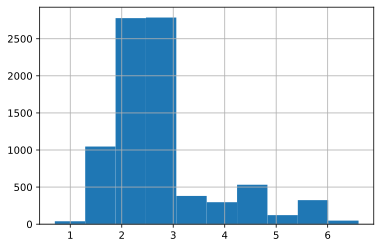

In [199]:
data.engineDisplacement.hist()

Как мы видим, распределение близко к нормальному, но возможно после логарифмирования показатели станут лучше.

### enginePower

Признак отражает мощность двигателя автомобиля. Посмотрим на уникальные значения:

In [200]:
data.enginePower.unique()

array(['220 N12', '313 N12', '218 N12', '136 N12', '190 N12', '340 N12',
       '245 N12', '316 N12', '170 N12', '160 N12', '231 N12', '388 N12',
       '180 N12', '367 N12', '115 N12', '184 N12', '177 N12', '455 N12',
       '422 N12', '163 N12', '249 N12', '272 N12', '224 N12', '122 N12',
       '557 N12', '333 N12', '306 N12', '156 N12', '150 N12', '264 N12',
       '450 N12', '555 N12', '407 N12', '130 N12', '400 N12', '204 N12',
       '469 N12', '192 N12', '210 N12', '211 N12', '239 N12', '200 N12',
       '350 N12', '420 N12', '300 N12', '381 N12', '265 N12', '258 N12',
       '390 N12', '197 N12', '120 N12', '544 N12', '193 N12', '235 N12',
       '233 N12', '394 N12', '355 N12', '421 N12', '320 N12', '585 N12',
       '105 N12', '280 N12', '194 N12', '132 N12', '639 N12', '250 N12',
       '335 N12', '510 N12', '116 N12', '360 N12', '238 N12', '225 N12',
       '625 N12', '571 N12', '507 N12', '286 N12', '372 N12', '575 N12',
       '408 N12', '310 N12', '354 N12', '255 N12', 

Избавимся от дополнительной информации в данных:

In [201]:
data['enginePower'] = data['enginePower'].apply(lambda x: str(x).replace(' N12', ''))

Проверим результат:

In [202]:
data.enginePower.unique()

array(['220', '313', '218', '136', '190', '340', '245', '316', '170',
       '160', '231', '388', '180', '367', '115', '184', '177', '455',
       '422', '163', '249', '272', '224', '122', '557', '333', '306',
       '156', '150', '264', '450', '555', '407', '130', '400', '204',
       '469', '192', '210', '211', '239', '200', '350', '420', '300',
       '381', '265', '258', '390', '197', '120', '544', '193', '235',
       '233', '394', '355', '421', '320', '585', '105', '280', '194',
       '132', '639', '250', '335', '510', '116', '360', '238', '225',
       '625', '571', '507', '286', '372', '575', '408', '310', '354',
       '255', '435', '525', '591', '109', '462', '143', '279', '487',
       '560', '125', '609', '102', '290', '296', '230', '326', '269',
       '445', '580', '370', '401', '129', '500', '270', '140', '110',
       '476', '166', '321', '626', '252', '612', '113', '101', '240',
       '605', '700', '133', '95', '558', '271', '82', '530', '329', '517',
       '118', '

Замечательно, теперь переведем в числовой формат и посмотрим распределение значений:

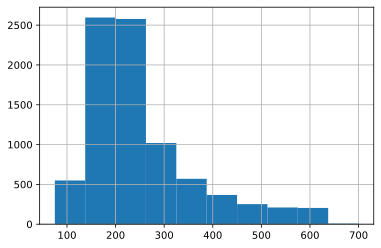

In [203]:
data['enginePower'] = data['enginePower'].apply(lambda x: int(x))
data.enginePower.hist()

Распределение близко к нормальному, но возможно необходимо будет логарифмировать для улучшения показателей. Отнесем к числовым признакам

### mileage

Признак содержит данные о пробеге продаваемого авто. Проверим данные:

In [204]:
data.mileage.unique()

array([350000,  15000, 166600, ..., 232777,  33700,  21291])

Данные чистые. Посмотрим на распределение признака:

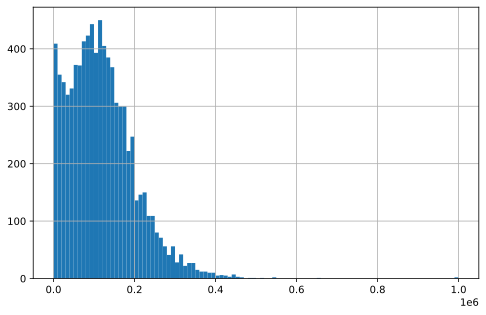

In [205]:
data.mileage.hist(figsize=(8, 5), bins=100)

Проверим на выбросы:

In [206]:
IQR = data['mileage'].quantile(0.75) - data['mileage'].quantile(0.25)
perc25 = data['mileage'].quantile(0.25)  # 25-й перцентиль
perc75 = data['mileage'].quantile(0.75)  # 75-й перцентиль

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR,
                                           l=perc75 + 1.5*IQR))

25-й перцентиль: 59246.0, 75-й перцентиль: 167084.0, IQR: 107838.0,  Границы выбросов: [-102511.0, 328841.0].


Посмотрим, сколько значений превышает границу:

In [207]:
data.mileage[data.mileage > 328841].count()

161

Как мы видим, значений действительно мало. Возможно они действительно являются выбросами, но существуют автомобили, у которых очень большой пробег. Поэтому предполагаемые выбросы оставим без изменений.

### modelDate

Данный признак содержит информацию о годе производства модели авто. Просмотрим уникальные значения:

In [208]:
data.modelDate.unique()

array([1984, 2011, 2005, 2016, 2009, 2008, 2007, 1989, 2001, 2006, 2013,
       2014, 2015, 2004, 2017, 2018, 2012, 2003, 2019, 2010, 2000, 1990,
       2002, 1998, 1993, 1994, 1999, 1995, 1971, 1996, 1985, 1975, 1992,
       1997, 1987, 1979, 1991, 1982, 1986, 1988, 1981, 1977, 1976])

Создадим признак - возраст автомобиля и заменим им текущий признак.

In [209]:
datetime.now().year

2022

In [210]:
data['model_time'] = data['modelDate'].apply(lambda x: datetime.now().year - x)

Теперь построим график распределения для наглядности:

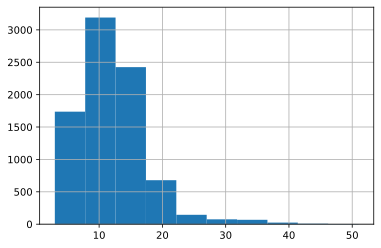

In [211]:
data['model_time'].hist()

### productionDate

Признак содержит информацию о годе производства авто. Проверим корреляцию между productionDate и model_time:

In [212]:
data[['model_time', 'productionDate']].corr()

,model_time,productionDate
model_time,1.000000,-0.964919
productionDate,-0.964919,1.000000


Очевидно, высокая корреляция. Для модели будет более чем достаточно признака model_time. productionDate можно удалять.

### Владение

Данный столбец отражает,сколько времени продавец владеет автомобилем. Посмотрим, сколько пропусков в данном столбце:

In [213]:
data.Владение.isna().sum()

5418

Посмотрим соотношение пропусков ко всему дата-сету:

In [214]:
data.Владение.isna().sum()/len(data.Владение)*100

64.86292350053873

Как видно, пропусков почти 65% дата-сета. Заполнение их каким-либо одним значением сыграет только плохую роль. Лучше данный столбец вообще не включать в обучение.

Посмотрим, как выглядят распределения числовых признаков:

In [215]:
data[['mileage', 'modelDate', 'engineDisplacement', 'enginePower']]

,mileage,modelDate,engineDisplacement,enginePower
0,350000,1984,3.0,220
1,15000,2011,3.0,313
2,166600,2005,2.5,218
3,147000,2005,2.0,136
4,24000,2016,2.0,190
...,...,...,...,...
8348,232777,2005,2.0,150
8349,33700,2013,2.0,190
8350,200000,2008,2.0,143
8351,72000,2013,3.0,310


## Теперь рассмотрим категориальные признаки.

### bodyType

Данный столбец отражает тип кузова автомобиля. Посмотрим на количество вариантов:

In [216]:
data['bodyType'].unique()

array(['универсал 5 дв.', 'купе', 'седан', 'внедорожник 5 дв.', 'родстер',
       'лифтбек', 'хэтчбек 3 дв.', 'хэтчбек 5 дв.', 'купе-хардтоп',
       'внедорожник 3 дв.', 'минивэн', 'кабриолет',
       'пикап двойная кабина', 'внедорожник открытый', 'компактвэн',
       'седан 2 дв.', 'лимузин'], dtype=object)

Проведем обработку данных:

In [217]:
# Выбираем первое слово для описания типа кузова
data['bodyType'] = data['bodyType'].astype(
    str).apply(lambda x: None if x.strip() == '' else x)
# Понижаем регистр первого слова
data['bodyType'] = data['bodyType'].apply(lambda x: x.split(' ')[0].lower())

Проверим распределение значений по типу кузова:

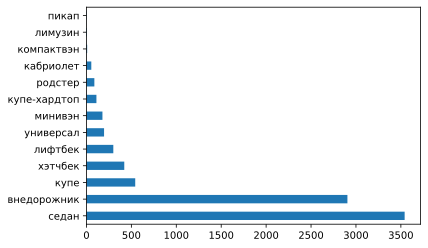

In [218]:
data['bodyType'].value_counts().plot.barh()

### brand

Данный столбец отражает название фирмы-производителя автомобиля. Проверим уникальные значения:

In [219]:
data['brand'].unique()

array(['MERCEDES', 'BMW', 'AUDI'], dtype=object)

Как мы видим, уникальных значений мало, можно оставить без изменений. Посмотрим распределение значений:

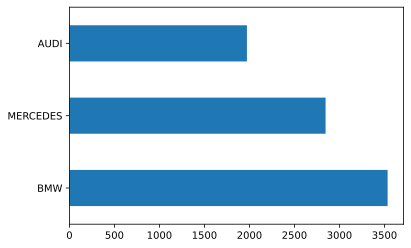

In [220]:
data['brand'].value_counts().plot.barh()

### color

Данный признак отражает цвет продаваемого автомобиля.  
Посмотрим уникальные значения и их количество:

In [221]:
data['color'].unique()

array(['чёрный', 'белый', 'пурпурный', 'синий', 'коричневый', 'серый',
       'зелёный', 'серебристый', 'красный', 'оранжевый', 'голубой',
       'фиолетовый', 'бежевый', 'жёлтый', 'золотистый', 'розовый'],
      dtype=object)

In [222]:
data['color'].nunique()

16

Посмотрим распределение значений по цветам:

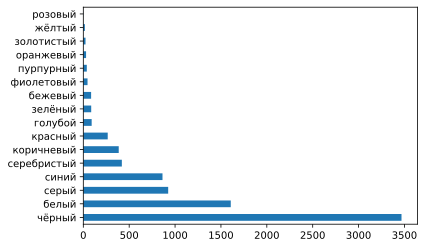

In [223]:
data['color'].value_counts().plot.barh()

### fuelType

Данный признак содержит данные о типе топлива, используемого в автомобиле. Посмотрим на уникальные значения:


In [224]:
data['fuelType'].value_counts()

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuelType, dtype: int64

Посмотрим распределение признака:

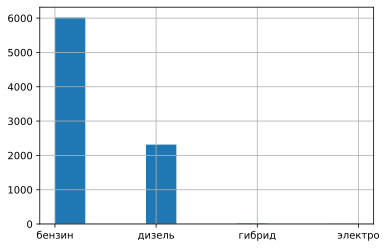

In [225]:
data['fuelType'].hist()

Как видно из графика, подавляющее большинство автомобилей используют бензиновое топливо. Отнесем признак к категориальным.

### model_info

Данный столбец отражает информацию о модели продаваемого автомобиля. Посмотрим количество уникальных значений:

In [226]:
data['model_info'].value_counts()

5ER         776
3ER         578
X5          501
E_KLASSE    490
A6          433
           ... 
None          1
Z8            1
COUPE         1
Z3M           1
W201          1
Name: model_info, Length: 122, dtype: int64

Мы имеем одну строчку без указания модели. Посмотрим, что это за строка:

In [227]:
data.loc[data['model_info'] == 'None']

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,model_time
2803,седан,MERCEDES,серый,Автомобиль в очень хорошем состоянии. Богатая ...,4.0,510,бензин,41000,2014,None,63 AMG S 4.0 AT (510 л.с.),4,2017,1099323364,SEDAN AUTOMATIC 4.0,автоматическая,3 или более,NaN,Дубликат,задний,Левый,1,3700000.0,8


Видим, что это Mercedes-седан. Посмотрим, возможно в комментарии указана модель:

In [228]:
data.iloc[2803]['description']

'Автомобиль в очень хорошем состоянии. Богатая комплектация. По всем вопросом звоните.'

Посмотрим на фотографию автомобиля и попробуем по изображению найти информацию о модели в интернете.

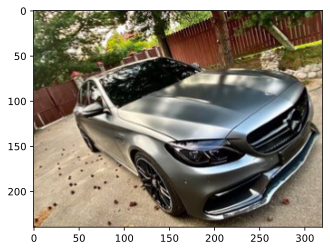

In [229]:
im = PIL.Image.open(os.path.join(DATA_PATH, 'img', 'img', '1099323364.jpg'))

plt.subplot(1, 1, 1)
plt.subplots_adjust(hspace=0.5)
plt.imshow(im)
plt.show()

Исходя из имеющихся об автомобиле данных и его изображении скорее всего это Mercedes-Benz E-Класс AMG 63 AMG S IV. Отсюда следует что признако можно заполнить значением E_KLASSE.

In [230]:
data['model_info'] = 'E_KLASSE'

### name

Столбец дублирует информацию из других столбцов. Единственное, что можно из него выделить - это наличие xDrive в автомобиле. Создадим новый признак:

In [231]:
data['xDrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)

Посмотрим как распределен признак:

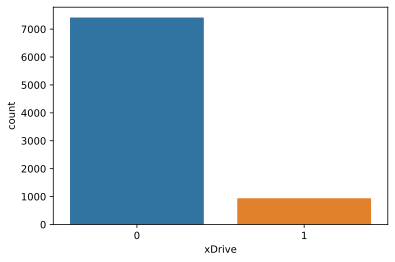

In [232]:
sns.countplot(x='xDrive', data=data)

Как мы видим, большая часть представленных автомобилей не имеет xDrive. Отнесем к бинарным признакам.

### numberOfDoors

Признак содержит информацию о количестве дверей авто. Посмотрим на уникальные значения:

In [233]:
data['numberOfDoors'].unique()

array([5, 2, 4, 3])

Как видно, никаких значений, вызывающих сомнения, нет. Проверим распределение признака:

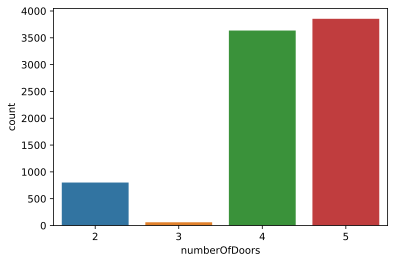

In [234]:
sns.countplot(x='numberOfDoors', data=data)

In [235]:
data['numberOfDoors'] = data['numberOfDoors'].astype('object')

### vehicleConfiguration

In [236]:
data['vehicleConfiguration']

0       WAGON_5_DOORS AUTOMATIC 3.0
1               COUPE AUTOMATIC 3.0
2               COUPE AUTOMATIC 2.5
3               SEDAN AUTOMATIC 2.0
4               SEDAN AUTOMATIC 2.0
                   ...             
8348            SEDAN AUTOMATIC 2.0
8349            SEDAN AUTOMATIC 2.0
8350            SEDAN AUTOMATIC 2.0
8351            SEDAN AUTOMATIC 3.0
8352        LIMOUSINE AUTOMATIC 6.0
Name: vehicleConfiguration, Length: 8353, dtype: object

Столбец содержит информацию из других столбцов. Информативности не несет. Признак можно удалить.

### Владельцы

In [237]:
data['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', nan],
      dtype=object)

Признак содержит информацию о количестве владельцев авто. Посмотрим пропуски:

In [238]:
data['Владельцы'].isna().sum()

1

Всего один пропуск. Посмотрим, что это за строка:

In [239]:
data[data['Владельцы'].isnull()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,model_time,xDrive
6665,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,4.2,360,бензин,160000,1999,E_KLASSE,4.2 AT (360 л.с.) 4WD,4,2001,1019330519,SEDAN AUTOMATIC 4.2,автоматическая,NaN,10 лет и 7 месяцев,Оригинал,полный,Левый,1,600000.0,23,0


Посмотрим описание, возможно там указано, сколько было владельцев:

In [240]:
data.iloc[6665]['description']

'машина в идеале! вложено примерно 400тыс.руб \r\n замена ГРМ, всех расходников,\r\n двигатель контрактный с пробегом в 120,000км.\r\n рулевая рейка новая (не ремонтная а НОВАЯ!)\r\n новый кардан. \r\n новые гидро натяжители цепей 40тыс.руб. \r\n новый бензонасос, \r\n новая подвеска "бильштайн" \r\n и т.д. \r\n комплектация максимальная- черное дерево! штатный (снимаемый) фаркоп, предпусковой подогреватель WEBASTO, кованные диски (германия) R-20, телефон.\r\nНА ВТОРОМ ФОТО СТАРЫЙ РУЛЬ! СЕЙЧАС НОВЫЙ С ДЕРЕВОМ КАК НА ПОСЛЕДНИХ ФОТО... (старый отдам в довесок)\r\nнедавно сделана полная разводка глушителей, с установкой новых банок на обе трубы (на фото можно разглядеть снизу) банки от ренж ровер спорт, звук КЛАСС!!!\r\n много писать, звоните...\r\nфото 100% мои!\r\nвозможен обмен на битый или горевший  микроавтобус (фольксваген Т-5) мультиван свежих годов.\r\nСАЛОНЫ И ПРОЧИЕ "ПОМОЩНИКИ" ИДИТЕ ЛЕСОМ!!!!!!!!!\r\nфото 100% мои!\r\nпродажа НЕ срочная!!! с большим торгом не звонить.'

К сожалению, комментарий оказался неинформативен. Заполним значение модой:

In [241]:
data['Владельцы'].fillna(data['Владельцы'].mode()[0], inplace=True)

Посмотрим результат:

In [242]:
data['Владельцы'].isna().sum()

0

Теперь оставим только числовые значения и приведем к числовому виду столбец:

In [243]:
data['Владельцы'] = data['Владельцы'].apply(lambda x: int(str(x)[0]))

Посмотрим распределение:

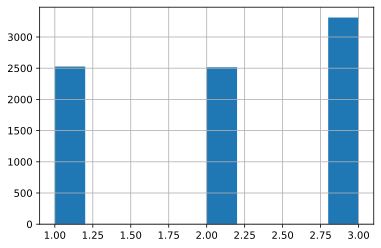

In [244]:
data['Владельцы'].hist()

Видно что автомобили с 3 владельцами немного преобладают над всеми остальными, но не сильно.

Т.к. значения данного признака можно сравнивать между собой, заменим значения на те, что больше отражают суть признака - чем больше владельцев у авто, тем хуже. Для этого заменим:  
1 - на 0,  
2 - на -1,  
3 - на -2.

In [245]:
data['Владельцы'] = data['Владельцы'].apply(lambda x: x - (x*2-1))

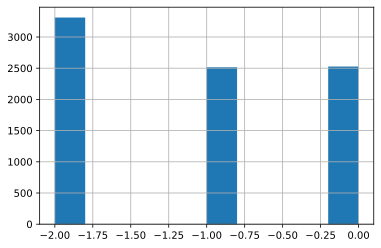

In [246]:
data['Владельцы'].hist()

### vehicleTransmission

Признак содержит информацию о типе коробки передач, используемой в транспортном средстве. Проверим уникальные значения:

In [247]:
data['vehicleTransmission'].unique()

array(['автоматическая', 'вариатор', 'роботизированная', 'механическая'],
      dtype=object)

Посмотрим распределение признака:

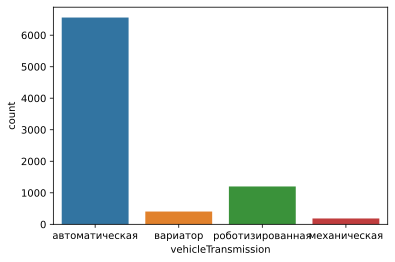

In [248]:
sns.countplot(x='vehicleTransmission', data=data)

Подавляющее большинство автомобилей имеют автоматическую коробку передач.

### ПТС

Данный признак содержит информацию о ПТС автомобиля. Проверим уникальные значения:

In [249]:
data['ПТС'].unique()

array(['Оригинал', 'Дубликат'], dtype=object)

Выведем график распределения признака:

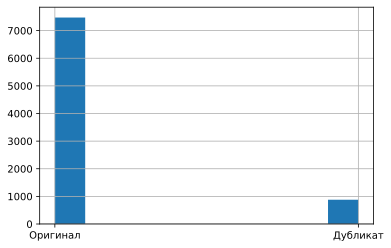

In [250]:
data.ПТС.hist()

Как видно из распределения - большая часть продавцов имеет оригинал ПТС. Пропусков не наблюдается.

### Привод

Признак содержит информацию о том, какой привод у транспортного средства. Посмотрим график распределения признака:

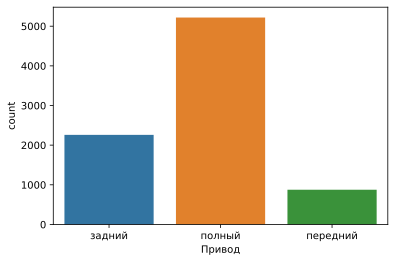

In [251]:
sns.countplot(x='Привод', data=data)

Видно, что большинство автомобилей имеют полный привод.

### Руль

Признак отражает положение руля в автомобиле. Посмотрим распределение признака:

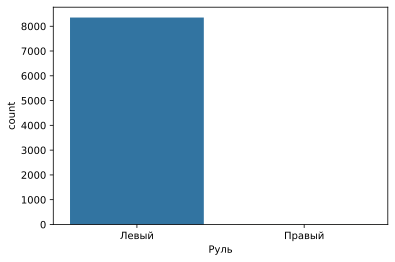

In [252]:
sns.countplot(x='Руль', data=data)

Почти все автомобили имеют левый руль.

Остался текстовый признак и признак, указывающий на соответствующую фотографию автомобиля.

### description

Данный столбец содержит комментарий о продаваемом автомобиле. В дальнейшем будет использоваться для NLP. Сейчас выделим на основе этого столбца признак, отражающий длину комментария:

In [253]:
data['comment_length'] = data.description.apply(lambda x: len(str(x)))

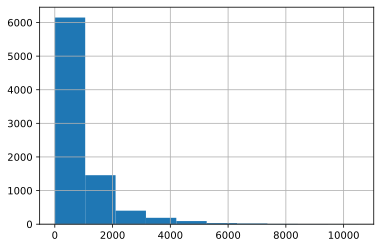

In [254]:
data.comment_length.hist()

Отнесем к числовым признакам

### sell_id

Этот признак нам в дальнейшем пригодится для того, чтобы находить изображения по идентификатору объявления. Для табличного обучения информативности не имеет.

### Целевой признак - price

Посмотрим график распределения целевого признака:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


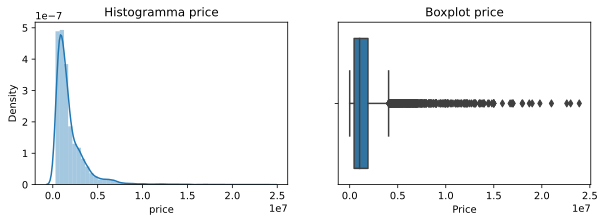

count    8.353000e+03
mean     1.519804e+06
std      1.873130e+06
min      0.000000e+00
25%      4.600000e+05
50%      1.030000e+06
75%      1.900000e+06
max      2.390000e+07
Name: price, dtype: float64

In [255]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title(f"Histogramma {'price'}")
sns.distplot((data[data['sample'] == 1]['price']), bins=50)

plt.subplot(1, 2, 2)
sns.boxplot(data['price'])
plt.xlabel('Price')
plt.title(f"Boxplot {'price'}", fontsize=12)
plt.show()
data.price.describe()

Видно, что данные сильно смещены влево. Посмотрим, как будет себя вести признак после логарифмирования:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


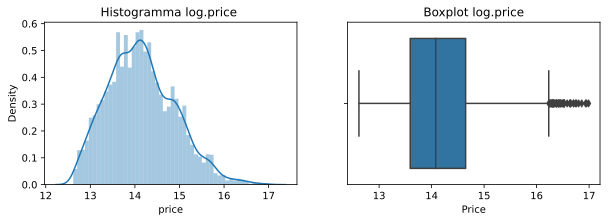

In [256]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title(f"Histogramma log.{'price'} ")
sns.distplot(np.log(data[data['sample'] == 1]['price']), bins=50)

plt.subplot(1, 2, 2)
sns.boxplot(np.log(data[data['sample'] == 1]['price']))
plt.xlabel('Price')
plt.title('Boxplot log.price', fontsize=12)
plt.show()

Теперь посмотрим зависимости некоторых столбцов от целевого:

Зависимость от возраста авто.

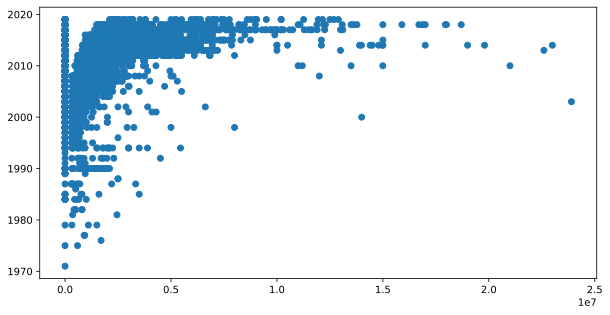

In [257]:
plt.figure(figsize=(10, 5))
plt.scatter((data.price), data.modelDate)

Из распределения видно, что чем более "свежий" автомобиль, тем выше на него цена. Но опять же, некоторые более старые автомобили могут стоить дорого из-за раритетности.  
Посмотрим также зависимость от привода:

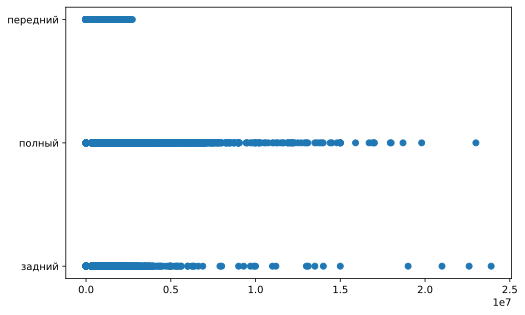

In [258]:
plt.figure(figsize=(8, 5))
plt.scatter((data.price), data['Привод'])

Из распределения хорошо видно, что наиболее высокая цена у полного привода, что логично.

Теперь сформируем перечень категориальных и числовых признаков:

In [259]:
# категориальные признаки
cat_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info',
                'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 
                'Привод', 'Руль']

# числовые признаки
num_features = ['mileage', 'model_time', 'engineDisplacement', 
                'enginePower', 'comment_length']

Необходимо посмотреть корреляционную зависимость наших признаков:

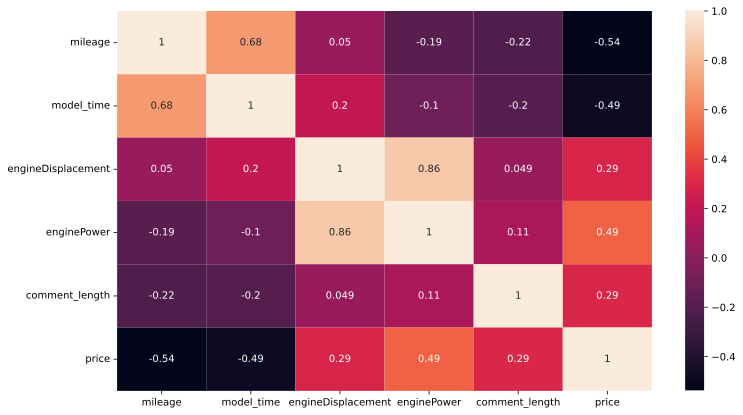

In [260]:
plt.figure(figsize=(12, 7))
sns.heatmap(data[data['sample'] == 1]
            [num_features + ['price']].corr(), annot=True)

Больше всего на таргет влияют признаки mileage, model_time, enginePower.  
Прослеживается высокая корреляция между мощньстью и объёмом двигателя, что очевидно. Однако, на мой взгляд она не достаточно высока, чтобы удалять один из признаков.

## Финальный этап обработки данных:

### Посмотрим, как выглядят распределения числовых признаков.

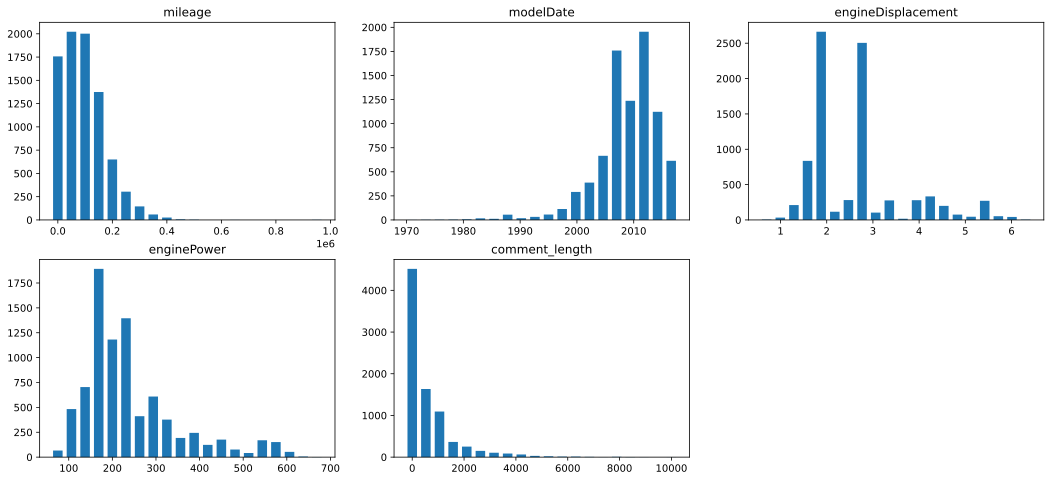

In [261]:
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize=(columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins=20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width=(bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()


visualize_distributions({
    'mileage': data['mileage'].dropna(),
    'modelDate': data['modelDate'].dropna(),
    'engineDisplacement': data['engineDisplacement'].dropna(),
    'enginePower': data['enginePower'].dropna(),
    'comment_length': data['comment_length'].dropna()
})

### Просмотрим распределение после логарифмирования:

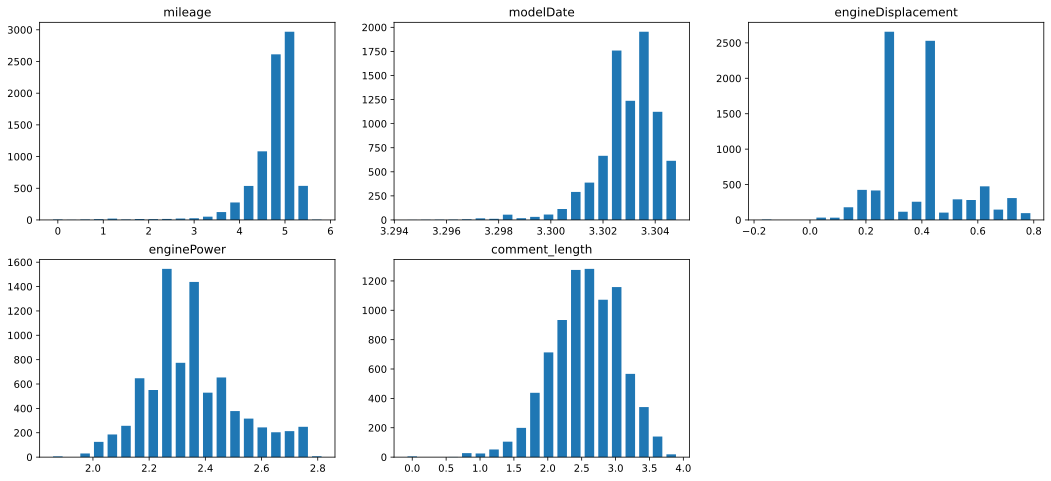

In [262]:
visualize_distributions({
    'mileage': np.log10(data['mileage'].dropna()),
    'modelDate': np.log10(data['modelDate'].dropna()),
    'engineDisplacement': np.log10(data['engineDisplacement'].dropna()),
    'enginePower': np.log10(data['enginePower'].dropna()),
    'comment_length': np.log10(data['comment_length'].dropna())
})

Распределения стали выглядеть лучше. Таким образом перед нормализацией возьмём логарифм для каждого числового признака.

### Тестируем масштабаторы.

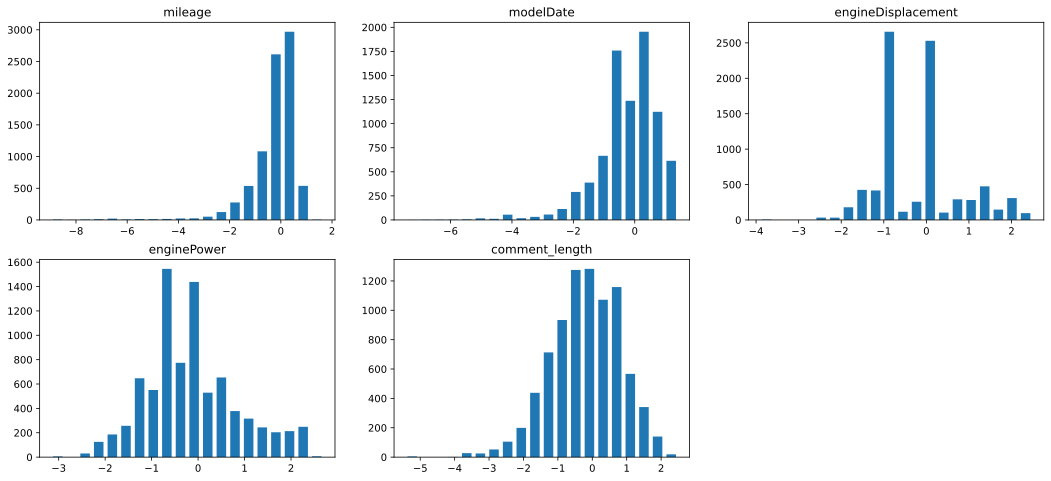

In [263]:
MinMaxScaler, RobustScaler, StandardScaler
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = RobustScaler()

scaler = scaler1

visualize_distributions({
    'mileage': scaler.fit_transform(np.log10(data[['mileage']].dropna()))[:, 0],
    'modelDate': scaler.fit_transform(np.log10(data[['modelDate']].dropna()))[:, 0],
    'engineDisplacement': scaler.fit_transform(np.log10(data[['engineDisplacement']].dropna()))[:, 0],
    'enginePower': scaler.fit_transform(np.log10(data[['enginePower']].dropna()))[:, 0],
    'comment_length': scaler.fit_transform(np.log10(data[['comment_length']].dropna()))[:, 0]
})

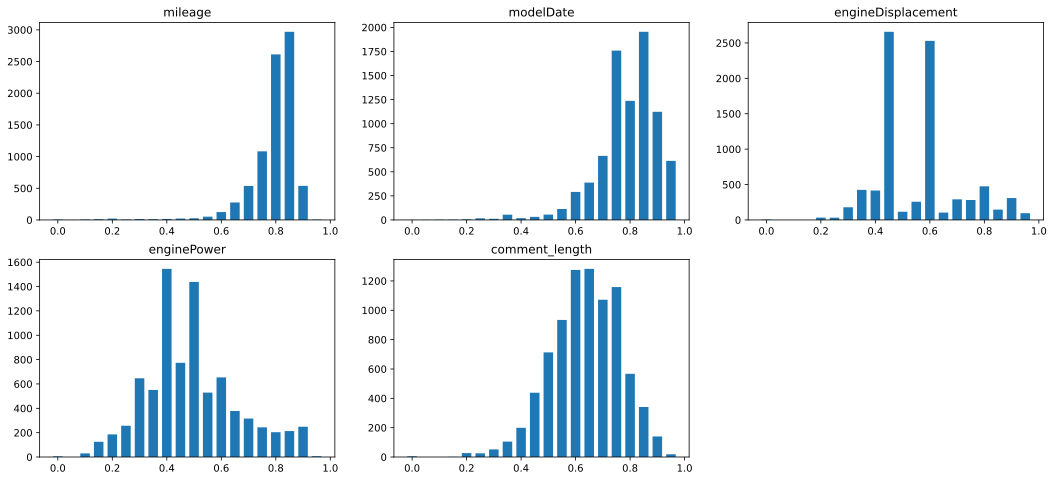

In [264]:
scaler = scaler2

visualize_distributions({
    'mileage': scaler.fit_transform(np.log10(data[['mileage']].dropna()))[:, 0],
    'modelDate': scaler.fit_transform(np.log10(data[['modelDate']].dropna()))[:, 0],
    'engineDisplacement': scaler.fit_transform(np.log10(data[['engineDisplacement']].dropna()))[:, 0],
    'enginePower': scaler.fit_transform(np.log10(data[['enginePower']].dropna()))[:, 0],
    'comment_length': scaler.fit_transform(np.log10(data[['comment_length']].dropna()))[:, 0]
})

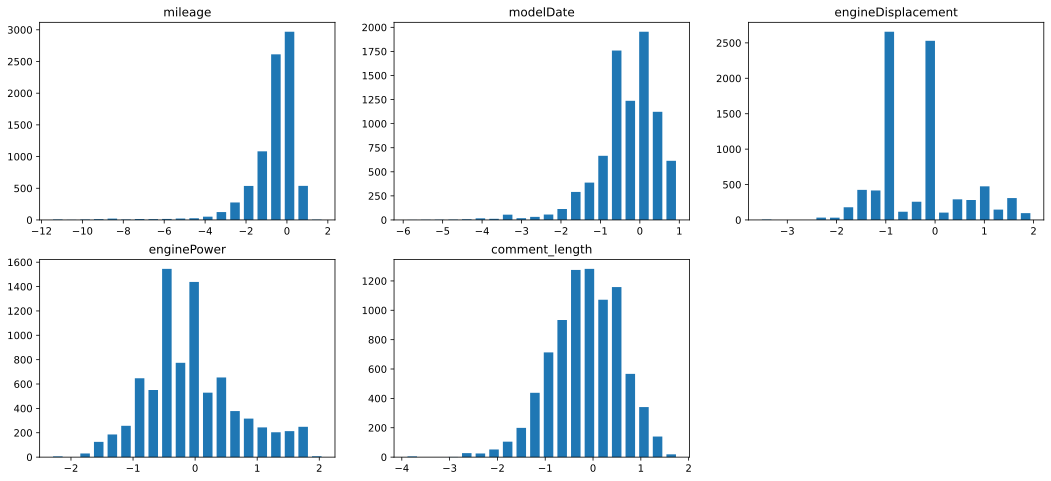

In [265]:
scaler = scaler3

visualize_distributions({
    'mileage': scaler.fit_transform(np.log10(data[['mileage']].dropna()))[:, 0],
    'modelDate': scaler.fit_transform(np.log10(data[['modelDate']].dropna()))[:, 0],
    'engineDisplacement': scaler.fit_transform(np.log10(data[['engineDisplacement']].dropna()))[:, 0],
    'enginePower': scaler.fit_transform(np.log10(data[['enginePower']].dropna()))[:, 0],
    'comment_length': scaler.fit_transform(np.log10(data[['comment_length']].dropna()))[:, 0]
})

Лучше всего себя показал StandartScaler. Поэтому в финальной обработке будем использовать его.

### Преобразование категориальных признаков

Преобразуем категориальные признаки следующим образом:  
* {brand, ПТС, Привод, Руль} будут закодированы с помощью One-Hot Encoder;
* {fuelType, numberOfDoors, vehicleTransmission} будут закодированы с помощью BinaryEncoder;
* {bodyType, color, model_info} будут закодированы с помощью Target Encoder реализованного под капотом CatBoost;

In [266]:
features_for_OneHot_Encoder = ['brand', 'ПТС', 'Привод', 'Руль']
features_for_BinaryEncoder = ['fuelType', 'numberOfDoors', 'vehicleTransmission']
features_for_CatBoost = ['bodyType', 'color', 'model_info']

In [267]:
def process_data(df_input):

    df_output = df_input.copy()

    # Удалим неиспользуемые столбцы
    df_output.drop(['modelDate', 'productionDate', 'description', 'sell_id',
                    'vehicleConfiguration', 'Владение', 'name', ],
                    axis=1, inplace=True)

    ############################### Нормализация ###############################

    scaler = StandardScaler()
    for column in num_features:
        df_output[column] = scaler.fit_transform(
            np.log10(df_output[[column]]))[:, 0]

    ################## Преобразование категориальных признаков #################
    # One-Hot Encoding:
    df_output = pd.get_dummies(
        df_output, columns=features_for_OneHot_Encoder, dummy_na=False)
    
    # Binary Encoding
    bn = BinaryEncoder(cols=features_for_BinaryEncoder)
    df_output = bn.fit_transform(df_output)

    return df_output

### Применение преобразования

In [268]:
df = process_data(data)

## Split data

Разделим данные.

In [269]:
train_df = df.query('sample == 1').drop(['sample'], axis=1)
test_df = df.query('sample == 0').drop(['sample'], axis=1)

X = train_df.drop(['price'], axis=1)
y = train_df['price'].values     # наш таргет
X_sub = test_df.drop(['price'], axis=1)

# Model 1: CatBoostRegressor

Разделим train на обучающую и валидационную выборку. На валидацию выделим 15%.

In [270]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

Теперь обучим наш CatBoosRegressor:

In [280]:
cat_boost_model = CatBoostRegressor(iterations=5000,  # Количество итераций
                          depth=12,
                          learning_rate = 0.02,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,  # Прерывание, если не улучшается 500 итер
                          # task_type='GPU',
                          silent=True,
                          l2_leaf_reg=8, 
                          random_strength=0.3,
                          cat_features=features_for_CatBoost
                          )
# обучим модель
cat_boost_model.fit(X_train, np.log(y_train),
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=100,
          use_best_model=True,
          # plot=True
          )

# оцениваем точность
predict_catboost = np.round(np.exp(cat_boost_model.predict(X_test)))
print("Точность модели по метрике MAPE: "
      f"{(mape(y_test, predict_catboost))*100:0.2f}%")


0:	learn: 0.0419671	test: 0.0424267	best: 0.0424267 (0)	total: 232ms	remaining: 19m 21s
100:	learn: 0.0140416	test: 0.0143078	best: 0.0143078 (100)	total: 14.6s	remaining: 11m 50s
200:	learn: 0.0100604	test: 0.0109350	best: 0.0109350 (200)	total: 24.9s	remaining: 9m 53s
300:	learn: 0.0090881	test: 0.0103745	best: 0.0103745 (300)	total: 35.1s	remaining: 9m 8s
400:	learn: 0.0085715	test: 0.0101993	best: 0.0101993 (400)	total: 45.3s	remaining: 8m 39s
500:	learn: 0.0082099	test: 0.0101079	best: 0.0101079 (499)	total: 55.4s	remaining: 8m 17s
600:	learn: 0.0079626	test: 0.0100511	best: 0.0100511 (599)	total: 1m 5s	remaining: 7m 58s
700:	learn: 0.0076933	test: 0.0099964	best: 0.0099964 (700)	total: 1m 15s	remaining: 7m 40s
800:	learn: 0.0074613	test: 0.0099701	best: 0.0099683 (785)	total: 1m 24s	remaining: 7m 25s
900:	learn: 0.0072068	test: 0.0099426	best: 0.0099426 (899)	total: 1m 35s	remaining: 7m 12s
1000:	learn: 0.0069411	test: 0.0099256	best: 0.0099250 (981)	total: 1m 45s	remaining: 7m
1

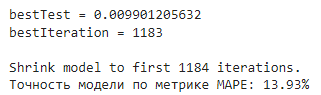

Результаты неплохие.
При уменьшении learning_rate модель сильно переобучается и  результаты ухудшаются на порядок.

### Submission

Создадим сабмит:

In [ ]:
if is_colab:
    path = SAVE_PATH
else:
    path = WORK_PATH
sub_predict_catboost = np.round(np.exp(cat_boost_model.predict(X_sub)))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv(os.path.join(SAVE_PATH, 'cat_boost_subm.csv'), index=False)

Уже на данном этапе результат лучше чем у baseline. 

Теперь разработае нейронную сеть.

# Model 2: Нейронная сеть

### 5.1. Simple Dense NN

Создадим простую Dense сеть.

На данном этапе было перепробовано несколько подходов с различным количеством и размером dense-слоев, функциями активации, количеством dropout-слоев. Наиболее удачным оказался вариант с активацией relu всех dense-слоев и kernel-регуляризацией. были исследованы другие способы регуляризации, но результат получался хуже.

Финальный вариант исследуемой сети представлен ниже:

In [ ]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, kernel_regularizer=regularizers.l2(
    l2=1e-6), activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(128, kernel_regularizer=regularizers.l2(
    l2=1e-5), activation="relu"))
model.add(L.Dropout(0.25))
model.add(L.Dense(1, activation="linear"))

Посмотрим структуру модели:

In [ ]:
model.summary()

Укажем оптимизатор с скоростью обучения 0.005 и скомпилируем модель:

In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

Пропишем наши коллбеки:
* earlystop - Для прерывания обучения в случае, когда нет положительного результата на протяжении **patience** эпох.
* checkpoint - Сохраняет лучшие веса модели

In [ ]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### 5.2. Fit

Обучаем нашу простую модель в течение 500 эпох. По факту, до конца это обучение дойдет вряд ли, потому что рано или поздно сработает EarlyStopping, который прервет процесс обучения, если не было положительной динамики 50 эпох. Валидацию проводим на валидационной части нашего дата-сета.

In [ ]:
history = model.fit(X_train, (y_train),
                    batch_size=512,  # размер батча
                    epochs=500,  # количество эпох для обучения
                    validation_data=(X_test, (y_test)),  # данные для валидации
                    callbacks=callbacks_list,  # список  наших коллбэков
                    verbose=0,  # параметр, отвечающий за выведение прогресс-бара
                    )

Посмотрим график Loss-функции:

In [ ]:
plt.title('Loss Function')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

Из графика видно, что вначале происходит резкий спад функции, но потом понижение происходит очень медленно, и к ~ 250 эпохе срабатывает прерывание выполнения из-за отсутствия положительного результата.

Сохраним модель и загрузим лучшие веса:

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

Проверим исследуемую метрику:

In [ ]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

Метрика получилась гораздо лучше, чем при использовании CatBoostRegressor'a, значит мы движемся в правильном направлении.

Сделаем сабмит:

In [ ]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:, 0]
sample_submission.to_csv('nn1_submission.csv', index=False)

На данном этапе я получил результат mape:11.36% на тестовой выборке, что улучшило предыдущий результат почти на пол процента.

До этого был сабмит с modelDate вместо productionDate - результат mape был примерно 12.15%.

Результат получился еще лучше, чем предыдущий. Значит, в данном случае наша нейронная сеть лучше решает поставленную задачу. Это дает несколько поводов для размышления, что делать дальше, чтобы еще сильнее улучшить исследуемую метрику. На данном этапе есть несколько вариантов: 
* Исследовать различные варианты архитектуры сети и ее параметры дальше
* Исследовать известные готовые варианты табличных нейронных сетей
* Попробовать дополнить архитектуру сети, сделав из нее multi-input сеть

Мы выберем последний вариант, так как помним, есть данные, которые мы до сих пор не использовали в обучении. Перейдем к созданию первой multi-input сети.

# 6. Model 4: NLP + MLP Multi Input NN

Для данной модели мы будем использовать две сети:
* NLP для обработки столбца description
* MLP, созданная ранее, для табличных данных

Для начала посмотрим, как выглядят данные в столбце:

In [ ]:
data.description

Мы видим, что столбец представляет собой комментарий к продаваемому автомобилю. В нем присутствует мусор, от которого нужно будет избавиться. План действий будет примерно следующим:
* Очистим строки от ненужных символов
* Проведем лемматизацию строк
* Уберем стоп-слова из строк
* Проведем токенизацию текста
* Проведем векторизацию текста

## 6.1. Лемматизация

    Данный этап стал для меня первым камнем преткновения. Сначала была идея использовать BERT, но моих знаний оказалось недостаточно, чтобы понять как его полноценно использовать. Потом я пытался использовать spacy для обработки текста, но она отказалась подгружать русскую библиотеку слов, а предлогаемые неофициальные решения со словарями мне показались не слишком подходящими. Поэтому я вернулся к тому, с чего начинал : pymorphy2 для лемматизации слов и nltk для удаления стоп-слов.

Суть лемматизации заключается в том, чтобы вернуть каждое слово к его изначальной словоформе. Это нужно, чтобы не считать разные формы слова "уникальными" при обработке текста.

Загрузим морфологический анализатор и скопируем данные из исходного дата-сета:

In [ ]:
morphy = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

Создадим паттерн с "мусорными" символами в строках ( обнавлялся несколько раз в процессе обработки текста, каждый раз находились новые уникальные значения) и напишем функцию для лемматизации:

In [ ]:
# Паттерн с символами
trash_sym = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-–»«•∙·✔➥●☛“”°№₽®]+"

# функция для лемматизации текста:


def lemma(text):
    text = text.lower()  # понижаем регистр
    text = re.sub(trash_sym, ' ', text)  # удаляем символы из паттерна
    strings = []  # создаем массив, в котором будут храниться лемматизированные строки
    for wrd in text.split():  # берем слово из строки
        wrd = wrd.strip()  # убираем пробелы до и после слова
        wrd = morphy.normal_forms(wrd)[0]  # приводим к нормальной форме
        strings.append(wrd)  # добавляем слово в строку массива
    return ' '.join(strings)  # вернем значения, разделив пробелами

Применим функцию к нашему nlp-датасету:

In [ ]:
strings_set = []
strings_set = df_NLP.apply(
    lambda df_NLP: lemma(df_NLP.description), axis=1)

Загрузим список русских стоп-слов:

In [ ]:
russian_stopwords = stopwords.words("russian")

Напишем функцию, которая которая будет проверять наши лемматизированные слова на наличие в списке стоп-слов:

In [ ]:
# функция для проверки на стоп-слова
def lineWithoutStopWords(line):
    line = line.split()  # разделяем на слова
    # возвращаем слово, если оно не в списке стоп-слов
    return [word for word in line if word not in russian_stopwords]


# применим функцию к нашим лемматизированым строкам слов
str_without_stop = [lineWithoutStopWords(line) for line in strings_set]

Укажем обучающую\валидационную и тестовую выборки:

In [ ]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

## 6.2. Токенизация

Пропишем параметры для токенизатора, с помощью которого будем проводить токенизацию текста:

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

Обучим токенизатор на полученном списке лемматизированых слов:

In [ ]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(str_without_stop)

Проверим результат:

In [ ]:
tokenize.word_index

Используем полученный список слов для векторизации текста из наших выборок:

In [ ]:
%%time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape, )

Выведем пример того, как теперь выглядит текст:

In [ ]:
print(text_train.iloc[6])
print(text_train_sequences[6])

## 6.3. RNN NLP

Создание сети для NLP забрало у меня довольно много времени по нескольким причинам:
1. Я пытался понять, как использовать SoTA решения для данной задачи, например GPT-2 (так до конца и не разобрался)
2. Я исследовал различные структуры NLP:
   * Менял количество слоев dense
   * Менял количество LSTM слоев
   * Менял количество юнитов в слоях
   * Менял количество Dropout слоев
   * Менял функции активации в слоях
   * Использовал различные варианты и положение слоев нормализации
   
Финальный вариант,представленный ниже, показал наиболее низкое значение MAPE, поэтому я оставил именно его:   

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LayerNormalization())
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(128, activation="sigmoid"))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(64,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

После создания NLP-сети мы переходим к сети для табличной обработки данных

## 6.4. MLP-сеть

Здесь я тоже провел довольно много времени, перебирая различные варианты архитектуры сети, параметров слоев, вариантов регуляризации, в том числе ее значений, и функций активации. В начале была идея попробовать использовать для обработки данных TabNet, но, как и в предыдущем пункте, я не смог полностью разобраться, как мне ее включить в общую конструкцию.

Финальным вариантом, на котором я остановился, является архитектура, представленная ниже:

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, kernel_regularizer=regularizers.l2(
    l2=1e-6), activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(128, kernel_regularizer=regularizers.l2(
    l2=1e-5), activation="relu"))
model_mlp.add(L.Dropout(0.25))

Теперь, когда обе сети готовы, создадим "голову", которая будет объединять выходы наших сетей воедино.

## 6.5. Multiple Inputs NN

На этом этапе было рассмотрено несколько вариантов с различными функциями активации и количеством юнитов. Как и ранее, финальный вариант, который дал наиболее низкую MAPE, представлен ниже:

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(32, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

Выведем описание модели:

In [ ]:
model.summary()

## 6.6. Обучение

В качестве оптимизатора я исследовал Adam и Adamax. Adam в данном случае сходится гораздо быстрее и дает более стабильные значения исследуемой метрики. Начальную скорость обучения выберем 0.01. 

Проведем компиляцию модели:

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
# Проведем компиляцию модели
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

В процессе исследования, было выявлено, что фиксированная скорость обучения дает не самый хороший результат. Поэтому, помимо уже имеющихся коллбэков, которые мы упоминали ранее при обучении табличной сети, я добавил ReduceLROnPlateau, который уменьшает скорость обучения, в случае когда нет улучшения исследуемой метрики в течение **patience** эпох. 

Объявим коллбэки:

In [ ]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=15, restore_best_weights=True,)
lr_scheduler = ReduceLROnPlateau(monitor='val_MAPE',
                                 factor=0.5,  # уменьшим lr в 2 раза
                                 patience=5,  # если нет улучшения через 2 эпохи - уменьшить lr
                                 min_lr=0.0001,  # минимальная скорость обучения
                                 verbose=1,  # выводить сообщения об уменьшении скорости
                                 mode='auto')  # выбранный способ отслеживания метрики
callbacks_list = [checkpoint, earlystop, lr_scheduler]

Теперь приступим к обучению модели. Оно проходит довольно быстро. Фактически, мы все равно сталкиваемся с тем, что процесс обучения прерывается с помощью EarlyStopping. Но с использованием ReduceLROnPlateau точность удалось несколько повысить по сравнению с предыдущими результатами исследований.

Запустим обучение модели:

In [ ]:
# Запустим обучение модели
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500,
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                    )

Когда обучение завершилось, посмотрим на график нашей функции потерь:

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

Мы видим, что на определенном промежутке обучения график ведет себя "неспокойно". Это может быть связано с тем, что в начале мы используем довольно большую скорость обучения, быстро спускаемся в "плато", и пока скорость обучения не уменьшится, возникают те самые скачки функции потерь.

Сохраним лучшие веса модели:

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

Посмотрим значение полученной метрики:

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

Метрика получилась немного хуже, чем в предыдущем пункте. Имеется несколько догадок, почему это может быть, но об этом в конце пункта.

In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:, 0]
sample_submission.to_csv('nn2_submission.csv', index=False)

На данном этапе исследования было достигнуто значение MAPE=11.38%. Не самый хороший результат: на 0.03% хуже, чем у простой табличной сети. Я долго размышлял, с чем это может быть связано, и пришел к следующим вариантам:
* Не совсем оптимальные архитектуры используемых сетей
* Недостаточно хорошо очищены данные столбца description

Решение, которое приходит в голову: 
1. необходимо очистить столбец от emoji, которые используются в тексте. Помимо прочего, возможно использовать готовые сети станет действительно хорошим, видимым результатом, если учесть о том, как хорошо отзываются о работе сети GPT-2
2. добавить еще одну сеть в конструкцию multi-input сети, которая будет заниматься обработкой изображений

Я выбрал второй вариант, чтобы улучшить исследуемую метрику. Перейдем к созданию multi-input сети, состоящей из трех нейронных сетей.

# 7. Model 5: NLP+MLP+EffNetB6 Multi Input NN

На данном этапе, к multi-input сети, которую мы исследовали п.6. добавляется нейронная сеть, которая занимается обработкой изображений.

## 7.1. Image Data

Загрузим изображения автомобилей, которые будет обрабатывать наша сеть. Для начала проверим, что все имеющиеся у нас в input'е данные подгружены корректтно, выведем 9 изображений из папки img, используя для этого sell_id (вот и пригодился), как название изображения:

In [ ]:
# Укажем размер выводимого изображения
plt.figure(figsize=(10, 6))
# 9 случайных примеров из train
random_image = train.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values
# выведем 9 изображений автомобилей и цен к ним
for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Как видно, все вывелось корректно, никаких нареканий не имеется. Теперь загрузим все имеющиеся изображения с форматом 320х240:

In [ ]:
# Установим размер изображения
size = (320, 240)
# функция для загрузки изображений


def get_image_array(index):
    images_set = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)  # изменение размера
        images_set.append(image)  # добавляем изображение в массив
    images_set = np.array(images_set)
    print('images shape', images_set.shape, 'dtype', images_set.dtype)
    return(images_set)


# применим функцию для создания выборок
images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

Теперь, когда мы загрузили изображения, стоит вспомнить основные этапы проекта Ford vs Ferrari, который мы выполняли ранее. Для начала перейдем к настройкам аугментации изображений.

## 7.2. Настройки albumentations

Настройки, которые я использую для аугментации изображений, взяты из моего проекта [Ford vs Ferrari](https://www.kaggle.com/alexfoncrow/dst45-47-car-classification-sf/):

In [ ]:
augment_module = a.Compose([
    # добавляем размытие по Гауссу и шум с вероятностью 7%
    a.Blur(p=0.07),
    a.GaussNoise(p=0.07),
    #  Установим параметры сдвига,поворота и масштабирования, а также укажем их вероятность.
    a.ShiftScaleRotate(shift_limit=0.08,
                       scale_limit=0.05,
                       border_mode=4,
                       rotate_limit=20,
                       p=0.7),

    a.RGBShift(),
    a.HueSaturationValue(),  # случайный оттенок и насыщенность
    a.HorizontalFlip(),

    # установим случайную яркость и контрастность изображений с вероятностью 50%

    a.OneOf([
            a.RandomBrightnessContrast(
                brightness_limit=0.3, contrast_limit=0.3),
            a.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)],
            p=0.3)
])

# Выведем пример аугментации
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augment_module(image=images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Выше показан пример аугментации для имеющихся изображений.

## 7.3. Использование tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

 Для обработки данных при помощи tf.data.Dataset необходимо провести некоторую подготовку данных. Начнем с обучения нашего токенизатора:

In [ ]:
# обучение токенизатора для NLP
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(str_without_stop)

Теперь создадим функции, которые будут применяться к имеющимся у нас данным:

In [ ]:
# аугментация изображений
def process_image(image):
    return augment_module(image=image.numpy())['image']
# векторизация строки


def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen=MAX_SEQUENCE_LENGTH)
# применение векторизации к тексту


def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]
# функция  для применения вышеупомянутых функций к входным данным обучающей выборки


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image, ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price
# функция  для применения вышеупомянутых функций к входным данным валидационной и тестовой выборкок


def tf_process_val_dataset_element(image, table_data, text, price):
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


# использование tf.data.Dataset с использованием функций для обучающей выборки
train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
)).map(tf_process_train_dataset_element)
# использование tf.data.Dataset с использованием функций для валидационной выборки
test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
)).map(tf_process_val_dataset_element)
# использование tf.data.Dataset с использованием функций для тестовой выборки
y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
)).map(tf_process_val_dataset_element)

# проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__()

## 7.4. Fine-tune EfficientNet

На данном этапе я обращался к сайту paperswithcode, чтобы определить, какую сеть будет использовать оптимально. Были рассмотрены три сети, имеющиеся в tensorflow:
* EfficientNetB3
* EfficientNetB6
* EfficientNetB7

Я остановился на EffNetB6, т.к. она показалась мне наиболее оптимальной. Первоначально я взял B7, но она очень долго обучается, особенно если использовать ReduceLROnPLateau, я бы не уложился в квоту на сохранение.  B3 дал результат чуть хуже, чем B6.

Загрузим исследуемую модель:

In [ ]:
# загрузим модель без "головы" и укажем, что она может обучаться
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB6(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_model.trainable = True

Проведем Fine-Tuning, заморозив 1\4 нижних слоев модели:

In [ ]:
# Заморозим 1\4 нижних слоев модели
for layer in efficientnet_model.layers[:len(efficientnet_model.layers)//4]:
    layer.trainable = False

Посмотрим общее количество слоев в модели и какие из них могут обучаться:

In [ ]:
print(len(efficientnet_model.layers))

for layer in efficientnet_model.layers:
    print(layer, layer.trainable)

Добавим output-слой для нашей EfficienNet модели:

In [ ]:
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

Архитектура Табличной нейронной сети и RNN NLP взята из п.6.

In [ ]:
# Табличная нейронная сеть
tabular_model = Sequential([
    L.Input(shape=X.shape[1]),
    L.Dense(512, input_dim=X_train.shape[1], activation="relu"),
    L.Dropout(0.5),
    L.Dense(256, kernel_regularizer=regularizers.l2(
        l2=1e-6), activation="relu"),
    L.Dropout(0.5),
    L.Dense(128, kernel_regularizer=regularizers.l2(
        l2=1e-5), activation="relu"),
    L.Dropout(0.25)
])

In [ ]:
# Нейронная сеть для NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LayerNormalization(),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.Dense(128, activation="sigmoid"),
    L.Dropout(0.5),
    L.LSTM(64,),
    L.Dropout(0.25),
    L.Dense(64, activation="relu"),
    L.Dropout(0.25),
])

Теперь, когда мы создали все три нейронных сети, объединим их с помощью единой "головы". Здесь было исследовано 2 варианта головы с различным количеством юнитов в dense-слое (256 и 128), финальный вариант представлен ниже:

In [ ]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(128, activation="relu")(combinedInput)
head = L.Dense(1,)(head)
# Соберем наши части в одну модель
model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)
# посмотрим описание нашей модели
model.summary()

Теперь можно приступать к компиляции и обучению нашей модели:

In [ ]:
# укажем используемый оптимизатор и начальную скорость обучения
optimizer = tf.keras.optimizers.Adam(0.01)
# компиляция модели
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

Немного изменим список наших коллбэков:
1. Для EarlyStopping укажем 10 эпох для завершения обучения
2. Для ReduceLROnPlateau:
    * укажем 3 эпохи для изменения скорости обучения
    * установим минимальную скорость обучения 0.00001

In [ ]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop1 = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
lr_scheduler1 = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.5,  # уменьшим lr в 2 раза
                                  patience=3,  # если нет улучшения через 3 эпохи - уменьшить lr
                                  min_lr=0.00001,  # минимальная скорость обучения
                                  verbose=1,  # выводить сообщения об уменьшении скорости
                                  mode='auto')  # выбранный способ отслеживания метрики
callbacks_list1 = [checkpoint, earlystop1, lr_scheduler1]

Теперь обучим нашу модель (максимальное количество эпох = 60 для того, чтобы влезть в квоту на сохранение):

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=60,
                    validation_data=test_dataset.batch(30),
                    callbacks=callbacks_list1
                    )

Посмотрим, как выглядит функция потерь:

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

Как можно увидеть, в начале функция потерь валидационной выборки ведет себя нестабильно, то растет, то падает. Однако, при уменьшении скорости обучения, она становится более гладкой, резких скачков уже не наблюдается.

Загрузим лучшие веса модели и сохраним модель:

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

Посмотрим, как себя будет вести MAPE:

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

На валидационных данных мы получили метрику немного хуже, чем у простой табличной сети, но лучше чем у multi-input сети без обработки изображений. Это говорит нам о том, что работа проделана не зря и положительный результат наблюдается. Сделаем сабмит:

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:, 0]
sample_submission.to_csv('nn3_submission.csv', index=False)

На тестовых данных нам удалось улучшить метрику до 11.27%, это очень хороший результат.

Для дальнейшего улучшения модели, возможно, стоит рассмотреть более сложные сети, которые необходимо подгружать извне, руководствуясь paperswithcode. Это поможет улучшить обработку изображений, а если к этому добавить передовые нейронные сети для обработки табличных данных и NLP-сети, то метрика может вырасти довольно сильно.

Я же попробую применить Blending.

# 8. Blending и Final Submission

В качестве конечного результата используем комбинацию из результатов предсказаний некоторых предыдущих моделей:
1. CatBoostRegressor
2. Табличная нейронная сеть
3. NLP+MLP+EffNetB6 Multi Input NN

In [ ]:
blend_predict = (test_predict_catboost +
                 test_predict_nn1[:, 0] + test_predict_nn3[:, 0]) / 3
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

Мы добились самой хорошей метрики, которая у нас была! На этом этапе сделаем финальный сабмит:

In [ ]:
blend_sub_predict = (sub_predict_catboost +
                     sub_predict_nn1[:, 0] + sub_predict_nn3[:, 0]) / 3
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

Мы получили результат MAPE=10.87%! Данный результат является довольно хорошим достижением, с учетом того, что мы не затрагивали наиболее современные способы решения части задач. Этот сабмит является конечным, перейдем к выводам.

# 9. Выводы

Как и в предыдущих проектах, скажу - я не уверен, что все параметры и архитектуры сетей подобраны лучшим образом, но результат получился хороший. Была проведена предварительная обработка данных, выделены новые фичи, которые использовались при обучении модели. Здесь хочется отметить, что лучшим решением было бы найти фичу, которая еще сильнее погасила бы взаимную корреляцию между столбцами model_time и productionDate. Я думаю, это бы привело к улучшению метрики.

Были исследованы различные способы обработки текста для RNN NLP. Здесь, возможно, стоило бы избавиться от используемых в тексте emoji, либо же применить, например, BERT. Насколько я успел прочитать, он очень хорошо справляется с поставленными задачами. Плюс На основе BERT можно создать модель, которая будет работать вместо нашей RNN NLP.

С табличными данными примерно та же история, вместо стандартной сборки модели можно использовать сеть TabNet. Насколько я изучил материал по ней, в большинстве задач она показывает себя очень хорошо при работе с табличными данными.

Для обработки изображений - есть множество вариантов - от изменения настроек и способа аугментации до изменения обучаемой нами модели. Для достоверности - лучше выбирать модель в соответствии с современными решениями, но не забывать про ограничение на используемой платформе.

Проект получился очень интересный, я узнал много различных вещей, которые могут помочь мне в дальнейшем. Также сформировал несколько вопросов, на которые бы очень хотелось получить ответ.

По результатам выполнения  проекта были получены следующие метрики MAPE:
1. CatBoostRegressor - 11.87%
2. Smiple Dense NN - 11.36%
3. MLP + RNN NLP  - 11.38%
4. MLP + NLP + EffNetB6 - 11.27%
5. Blending(1+2+4) - 10.87%